--- Data Loading and Formatting Successful ---
Cleaned DataFrame columns: Index(['timestamp', 'ask_price_1', 'bid_price_1', 'ask_size_1', 'bid_size_1',
       'ask_price_2', 'bid_price_2', 'ask_size_2', 'bid_size_2', 'ask_price_3',
       'bid_price_3', 'ask_size_3', 'bid_size_3', 'ask_price_4', 'bid_price_4',
       'ask_size_4', 'bid_size_4', 'ask_price_5', 'bid_price_5', 'ask_size_5',
       'bid_size_5', 'ask_price_6', 'bid_price_6', 'ask_size_6', 'bid_size_6',
       'ask_price_7', 'bid_price_7', 'ask_size_7', 'bid_size_7', 'ask_price_8',
       'bid_price_8', 'ask_size_8', 'bid_size_8', 'ask_price_9', 'bid_price_9',
       'ask_size_9', 'bid_size_9', 'ask_price_10', 'bid_price_10',
       'ask_size_10', 'bid_size_10'],
      dtype='object')
                             timestamp  ask_price_1  bid_price_1  ask_size_1  \
0  2025-05-02 13:30:00.385066943+00:00        46.94        46.56         800   
1  2025-05-02 13:30:00.830134278+00:00        46.94        46.56         800   
2  

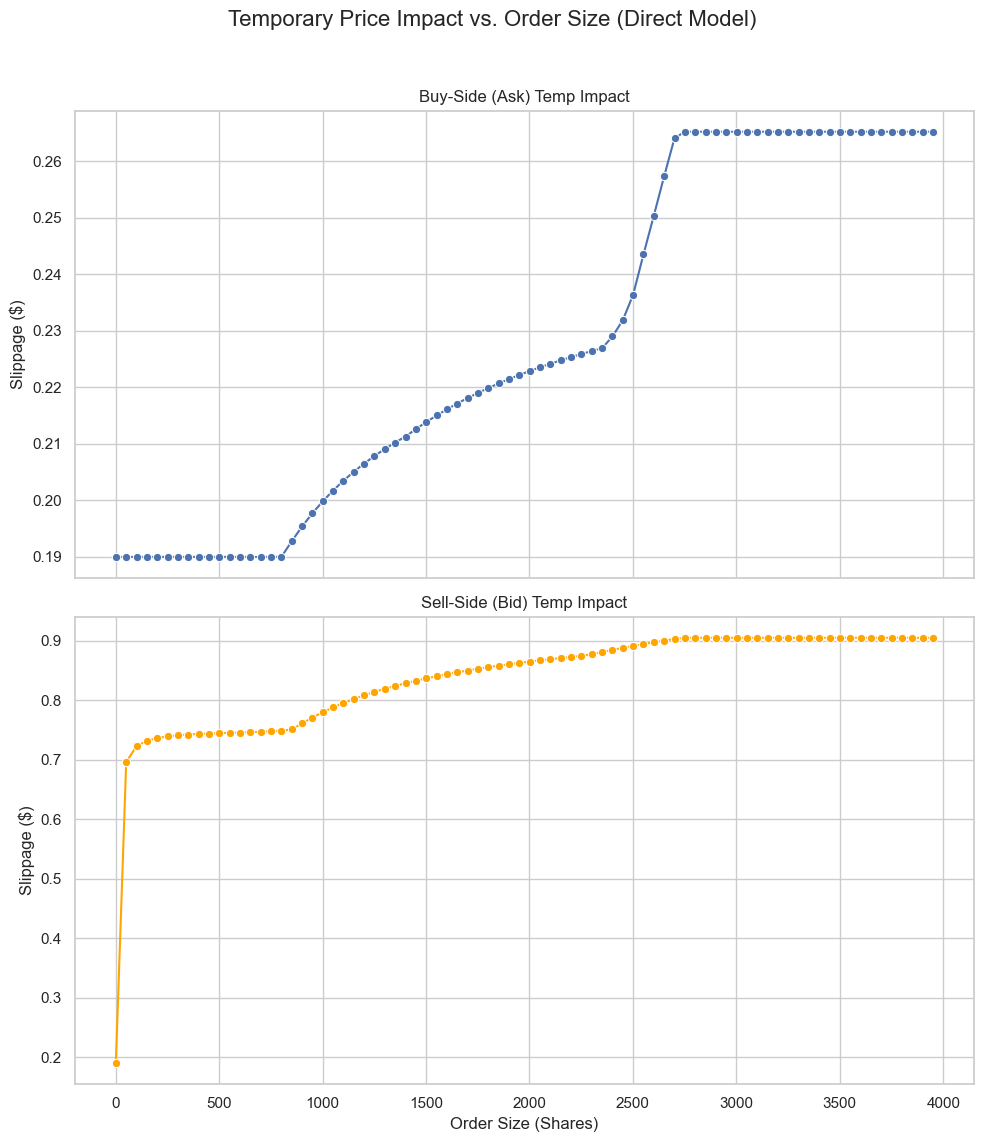

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit




file_path = 'Data\CRWV\CRWV_2025-05-02 00_00_00+00_00.csv' 
df_raw = pd.read_csv(file_path)


column_mapping = {
    'ts_event': 'timestamp' #
}

for i in range(10): 
    # Map prices
    column_mapping[f'ask_px_{i:02d}'] = f'ask_price_{i+1}'
    column_mapping[f'bid_px_{i:02d}'] = f'bid_price_{i+1}'
    # Map sizes
    column_mapping[f'ask_sz_{i:02d}'] = f'ask_size_{i+1}'
    column_mapping[f'bid_sz_{i:02d}'] = f'bid_size_{i+1}'


columns_to_keep = list(column_mapping.keys())
df_formatted = df_raw[columns_to_keep]

df_formatted = df_formatted.rename(columns=column_mapping)




print("--- Data Loading and Formatting Successful ---")
print("Cleaned DataFrame columns:", df_formatted.columns)
print(df_formatted.head())
print("\n")


# --- 2. Direct Impact Model: gt(x) ---

def calculate_temporary_impact(order_book_snapshot: pd.Series, order_size: int, side: str) -> float:
    """
    Calculates the temporary impact (slippage) for a market order by "walking the book".

    Args:
        order_book_snapshot: A pandas Series (a single row of the DataFrame) representing
                             the LOB at one point in time.
        order_size: The number of shares for the market order.
        side: The side of the order, either 'buy' or 'sell'.

    Returns:
        The total slippage in dollars per share. Returns NaN if the order can't be filled at all.
    """
    if side not in ['buy', 'sell']:
        raise ValueError("Side must be 'buy' or 'sell'")
        
    if order_size <= 0:
        return 0.0

    # Mid-price is calculated *before* the trade
    mid_price = (order_book_snapshot['ask_price_1'] + order_book_snapshot['bid_price_1']) / 2.0
    
    shares_remaining = float(order_size)
    total_cost = 0.0
    
    # Walk the book based on the side of the trade
    if side == 'buy':
        # A buy order consumes shares from the ASK side of the book
        for i in range(1, 11):
            if shares_remaining == 0:
                break
            price = order_book_snapshot[f'ask_price_{i}']
            available_shares = order_book_snapshot[f'ask_size_{i}']
            
            shares_to_fill = min(shares_remaining, available_shares)
            
            total_cost += shares_to_fill * price
            shares_remaining -= shares_to_fill
            
    elif side == 'sell':
        # A sell order consumes shares from the BID side of the book
        for i in range(1, 11):
            if shares_remaining == 0:
                break
            price = order_book_snapshot[f'bid_price_{i}']
            available_shares = order_book_snapshot[f'bid_size_{i}']
            
            shares_to_fill = min(shares_remaining, available_shares)
            
            total_cost += shares_to_fill * price
            shares_remaining -= shares_to_fill
    
    # Calculate final slippage based on filled shares
    shares_filled = order_size - shares_remaining
    
    if shares_filled == 0:
        # This happens if the book is empty on the trade side, or order size was 0
        return np.nan 

    avg_execution_price = total_cost / shares_filled
    
    if side == 'buy':
        # For a buy, slippage is how much *more* you paid than the mid-price
        slippage = avg_execution_price - mid_price
    else: # sell
        # For a sell, slippage is how much *less* you received than the mid-price
        slippage = mid_price - avg_execution_price
        
    return slippage

# --- 3. Analysis and Visualization ---

def generate_impact_curve_data(snapshot, max_order_size=4000, step=50, side='buy'):
    """
    Generates data points for the impact curve by calling the impact model repeatedly.
    """
    order_sizes = list(range(1, max_order_size + 1, step))
    slippages = [calculate_temporary_impact(snapshot, size, side) for size in order_sizes]
    
    return pd.DataFrame({
        'Order Size (Shares)': order_sizes,
        'Slippage ($)': slippages
    })

snapshot_t0 = df_formatted.iloc[0]

print(f"--- Analyzing Snapshot for Timestamp: {snapshot_t0['timestamp']} ---")
print(f"Best Ask: ${snapshot_t0['ask_price_1']:.2f} ({snapshot_t0['ask_size_1']} shares)")
print(f"Best Bid: ${snapshot_t0['bid_price_1']:.2f} ({snapshot_t0['bid_size_1']} shares)")
mid = (snapshot_t0['ask_price_1'] + snapshot_t0['bid_price_1']) / 2
print(f"Mid-Price: ${mid:.4f}")
print("\n")

# Generate the data for both buy and sell curves
buy_impact_data = generate_impact_curve_data(snapshot_t0, side='buy')
sell_impact_data = generate_impact_curve_data(snapshot_t0, side='sell')

# Plot the results
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Temporary Price Impact vs. Order Size (Direct Model)', fontsize=16)

# Buy-Side Impact Plot
sns.lineplot(ax=axes[0], data=buy_impact_data, x='Order Size (Shares)', y='Slippage ($)', marker='o')
axes[0].set_title('Buy-Side (Ask) Temp Impact')
axes[0].set_ylabel('Slippage ($)')

# Sell-Side Impact Plot
sns.lineplot(ax=axes[1], data=sell_impact_data, x='Order Size (Shares)', y='Slippage ($)', color='orange', marker='o')
axes[1].set_title('Sell-Side (Bid) Temp Impact')
axes[1].set_xlabel('Order Size (Shares)')
axes[1].set_ylabel('Slippage ($)')


plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()



--- Buy-Side Model: gt(x) = C * x^alpha ---
Fitted Cost Coefficient (C): 0.035924
Fitted Concavity (alpha): 0.2448
--------------------
--- Sell-Side Model: gt(x) = C * x^alpha ---
Fitted Cost Coefficient (C): 0.446501
Fitted Concavity (alpha): 0.0863
--------------------


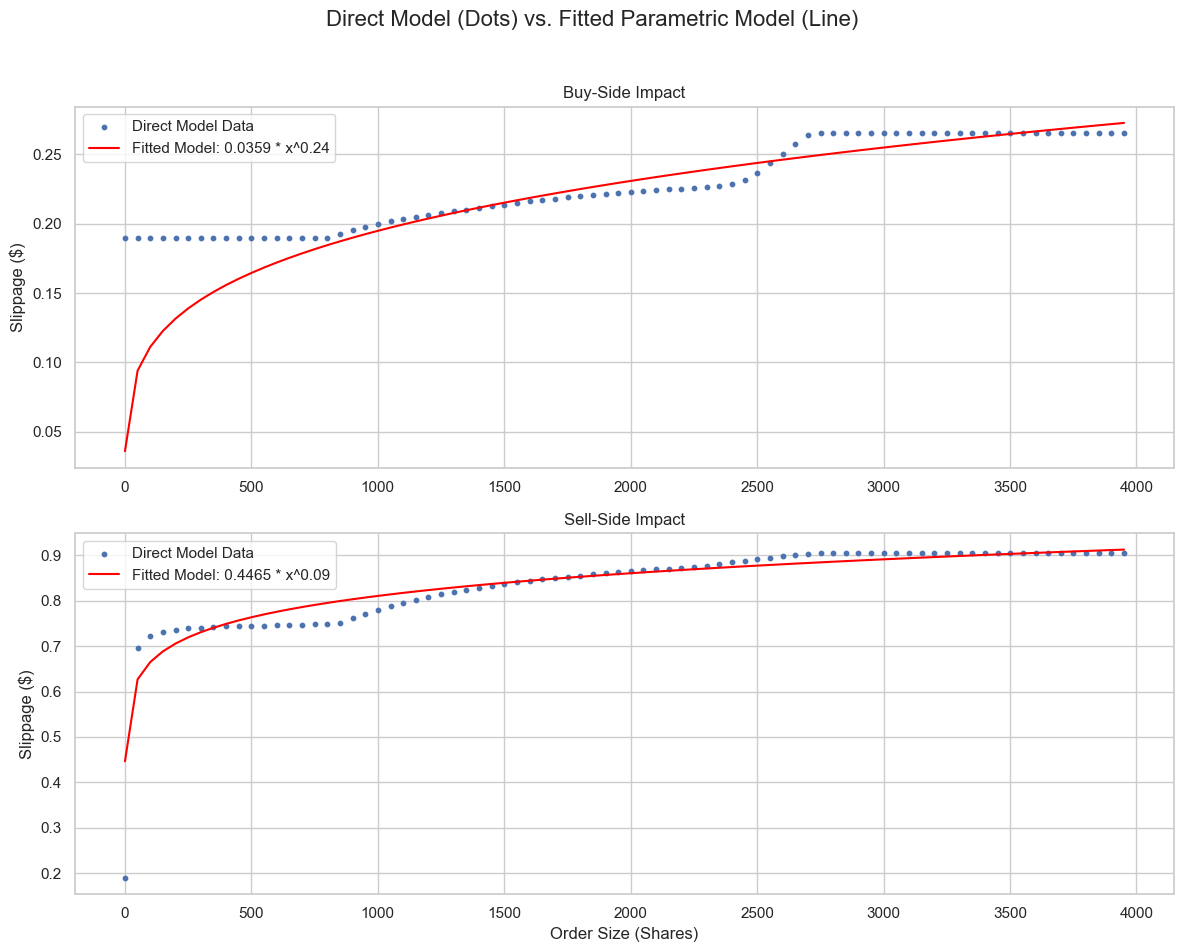

In [ ]:
# Model 2: Parametric Power-Law Model (as a function)
def power_law_model(x, C, alpha):
    """Our parametric model gt(x) = C * x^alpha"""
    return C * np.power(x, alpha)

snapshot_t0 = df_formatted.iloc[0]


buy_impact_data = generate_impact_curve_data(snapshot_t0, max_order_size=4000, step=50, side='buy').dropna()
buy_impact_data_fit = buy_impact_data[buy_impact_data['Order Size (Shares)'] > 800]


popt_buy, _ = curve_fit(power_law_model, buy_impact_data_fit['Order Size (Shares)'], buy_impact_data_fit['Slippage ($)'])
C_buy, alpha_buy = popt_buy
print(f"--- Buy-Side Model: gt(x) = C * x^alpha ---")
print(f"Fitted Cost Coefficient (C): {C_buy:.6f}")
print(f"Fitted Concavity (alpha): {alpha_buy:.4f}")
print("-" * 20)


sell_impact_data = generate_impact_curve_data(snapshot_t0, max_order_size=4000, step=50, side='sell').dropna()
sell_impact_data_fit = sell_impact_data[sell_impact_data['Order Size (Shares)'] > 50]


popt_sell, _ = curve_fit(power_law_model, sell_impact_data_fit['Order Size (Shares)'], sell_impact_data_fit['Slippage ($)'])
C_sell, alpha_sell = popt_sell
print(f"--- Sell-Side Model: gt(x) = C * x^alpha ---")
print(f"Fitted Cost Coefficient (C): {C_sell:.6f}")
print(f"Fitted Concavity (alpha): {alpha_sell:.4f}")
print("-" * 20)


fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Direct Model (Dots) vs. Fitted Parametric Model (Line)', fontsize=16)

# Buy-side plot
axes[0].scatter(buy_impact_data['Order Size (Shares)'], buy_impact_data['Slippage ($)'], label='Direct Model Data', s=10)
axes[0].plot(buy_impact_data['Order Size (Shares)'], power_law_model(buy_impact_data['Order Size (Shares)'], C_buy, alpha_buy), color='red', label=f'Fitted Model: {C_buy:.4f} * x^{alpha_buy:.2f}')
axes[0].set_title('Buy-Side Impact')
axes[0].set_ylabel('Slippage ($)')
axes[0].legend()
axes[0].grid(True)

# Sell-side plot
axes[1].scatter(sell_impact_data['Order Size (Shares)'], sell_impact_data['Slippage ($)'], label='Direct Model Data', s=10)
axes[1].plot(sell_impact_data['Order Size (Shares)'], power_law_model(sell_impact_data['Order Size (Shares)'], C_sell, alpha_sell), color='red', label=f'Fitted Model: {C_sell:.4f} * x^{alpha_sell:.2f}')
axes[1].set_title('Sell-Side Impact')
axes[1].set_xlabel('Order Size (Shares)')
axes[1].set_ylabel('Slippage ($)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [13]:
def engineer_features_for_stock(df_stock):
    """
    Takes raw order book data for a SINGLE stock and computes the time series
    of its liquidity parameters (C and alpha).
    """
    print(f"Starting feature engineering for stock...")
    param_list = []
    
    for index, row in df_stock.iterrows():
        params = {'timestamp': row['timestamp']}
        
        # Calculate for buy side
        try:
            buy_data = generate_impact_curve_data(row, side='buy').dropna()
            buy_data_fit = buy_data[buy_data['Slippage ($)'] > buy_data['Slippage ($)'].iloc[0] * 1.01] # Fit the curved part
            if len(buy_data_fit) > 2:
                popt, _ = curve_fit(power_law_model, buy_data_fit['Order Size (Shares)'], buy_data_fit['Slippage ($)'], maxfev=2000)
                params['C_buy'], params['alpha_buy'] = popt
            else:
                params['C_buy'], params['alpha_buy'] = np.nan, np.nan
        except Exception:
            params['C_buy'], params['alpha_buy'] = np.nan, np.nan

        # Calculate for sell side
        try:
            sell_data = generate_impact_curve_data(row, side='sell').dropna()
            sell_data_fit = sell_data[sell_data['Slippage ($)'] > sell_data['Slippage ($)'].iloc[0] * 1.01]
            if len(sell_data_fit) > 2:
                popt, _ = curve_fit(power_law_model, sell_data_fit['Order Size (Shares)'], sell_data_fit['Slippage ($)'], maxfev=2000)
                params['C_sell'], params['alpha_sell'] = popt
            else:
                params['C_sell'], params['alpha_sell'] = np.nan, np.nan
        except Exception:
            params['C_sell'], params['alpha_sell'] = np.nan, np.nan

        param_list.append(params)
        
    return pd.DataFrame(param_list).set_index('timestamp').interpolate().bfill()

# ==============================================================================
# PHASE 2: FORECASTING
# ==============================================================================

def forecast_params(series, n_periods):
    """
    Forecasts a time series for n_periods using a simple ARIMA model.
    """
    print(f"Forecasting series for {n_periods} periods...")
    # A simple ARIMA(p,d,q) model. Finding the right order is a separate task.
    # We use (5,1,0) as a reasonable default for financial time series.
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=n_periods)
    return forecast

# ==============================================================================
# PHASE 3: OPTIMIZATION (DYNAMIC PROGRAMMING)
# ==============================================================================

def find_optimal_schedule(total_shares, n_periods, C_forecast, alpha_forecast):
    """
    Finds the optimal trading schedule using Dynamic Programming.
    NOTE: This is computationally expensive.
    """
    print("Finding optimal schedule with Dynamic Programming...")
    total_shares = int(total_shares)
    
    # DP table J[t,s] stores the minimum cost for s shares with t periods remaining.
    J = np.full((n_periods + 1, total_shares + 1), np.inf)
    
    # Policy table P[t,s] stores the optimal trade for that state.
    P = np.zeros((n_periods + 1, total_shares + 1), dtype=int)

    # Base case: at t=0 (no time left), cost is 0 if no shares left, infinity otherwise
    J[0, 0] = 0

    # Iterate backwards from t=1 to n_periods
    for t in range(1, n_periods + 1):
        C = C_forecast[t-1]
        alpha = alpha_forecast[t-1]
        for s in range(total_shares + 1): # s = shares remaining
            for x in range(s + 1): # x = shares to trade now
                cost = (C * (x**alpha)) + J[t-1, s-x]
                if cost < J[t, s]:
                    J[t, s] = cost
                    P[t, s] = x
                    
    # Reconstruct schedule by moving forward
    schedule = []
    shares_left = total_shares
    for t in range(n_periods, 0, -1):
        trade_size = P[t, shares_left]
        schedule.append(trade_size)
        shares_left -= trade_size
        
    return list(reversed(schedule))